# IMPORT

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import re
from collections import defaultdict
from umap import UMAP
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Data Preprocessing

In [3]:
scaler = StandardScaler()

In [4]:
# reversed_df: Preprocessed dataset with reverse-coded items applied and Mahalanobis-based outlier handling completed.
# MA,DA_r, DA_f, EA  are subfator of MAS-scale
# In this Dataset, the subfator's scales are z-score
df = pd.read_csv('reversed_df.csv')
df = df.rename(columns={
    'Total_Q4': 'MAS',
    'MAS_MA_items': 'MA',
    'MAS_DA_r_items': 'DA_r',
    'MAS_DA_f_items': 'DA_f',
    'MAS_EA_items' : 'EA'
})
df.head(10)

,ID,SQ1,SQ2,SQ2_R,AG,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,...,Total_Q8,Total_Q9,Total_Q10,Total_Q11,Total_Q12,Total_Q13,MA,DA_r,DA_f,EA
0,1,1,55,4,1,3,3,3,4,4,...,9,46,27,3,0,16,-0.351316,0.009847,-0.355932,0.856635
1,2,1,69,5,1,3,3,3,4,4,...,15,45,38,2,1,36,0.447130,-0.533455,0.038453,0.856635
2,4,2,69,5,1,3,2,3,4,4,...,25,55,58,2,2,23,0.646741,0.553149,0.038453,0.269899
3,5,1,51,4,1,4,4,4,4,4,...,15,32,34,3,1,18,-0.950151,0.009847,-0.947509,1.052213
4,6,2,66,5,1,3,3,3,5,5,...,15,61,50,1,1,20,1.644799,-2.163361,0.827222,0.074320
5,7,1,55,4,1,4,4,3,4,4,...,25,69,54,0,1,19,1.445188,1.368102,1.615991,0.661056
6,8,1,49,3,1,4,4,4,4,4,...,16,67,51,2,1,32,0.447130,-0.125978,0.630030,0.661056
7,9,1,50,4,1,4,4,4,3,4,...,19,45,48,0,0,17,0.646741,0.009847,0.432837,0.661056
8,10,2,69,5,1,2,3,3,4,4,...,17,56,45,2,3,26,0.247518,0.824800,0.235645,-0.316837
9,11,2,37,3,1,3,3,5,5,5,...,22,52,59,2,8,28,-0.351316,0.009847,-0.553125,1.247792


In [5]:
#Q4 is MAS scale, eg, Q4_1 is number 4 in MAS_scale
cols = df.columns
grouped_cols = defaultdict(list)
for col in cols:
    m = re.match(r'(Q\d+)_', col)
    if m:
        grouped_cols[m.group(1)].append(col)
    
    elif col.startswith('SQ'):
        grouped_cols['SQ'].append(col)
    
    # 그 외
    else:
        grouped_cols[col].append(col)


In [6]:
# Extract the subset of items corresponding to Q4 for subsequent standardization and analysis.
# Standardize item responses (z-scoring) 
target_df = df[grouped_cols['Q4']]

X_z = scaler.fit_transform(target_df)
X_z

array([[-0.47040491, -1.6776682 , -0.11103295, ...,  0.24603593,
        -0.34126219,  0.26422528],
       [ 1.06947636,  1.16360534,  0.77250585, ...,  0.24603593,
        -1.06644435, -1.23874437],
       [ 0.29953573,  0.21651416, -0.11103295, ...,  0.24603593,
         1.10910213,  0.26422528],
       ...,
       [ 1.83941699,  2.11069652, -0.99457175, ...,  1.30982132,
         1.83428429,  1.0157101 ],
       [ 1.83941699,  2.11069652,  1.65604464, ...,  1.30982132,
         1.10910213,  1.0157101 ],
       [-0.47040491,  1.16360534, -3.64518814, ..., -0.81774947,
        -1.06644435,  1.0157101 ]], shape=(748, 25))

In [7]:
# Apply UMAP to project standardized item-level responses into a 2D space while preserving local similarity structure.
umap_model = UMAP(
    n_components=2,      
    n_neighbors= 10 ,     
    min_dist=0.05,       
    metric='euclidean',  
    random_state=42
)

X_umap = umap_model.fit_transform(X_z)

C:\Users\sdoub\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


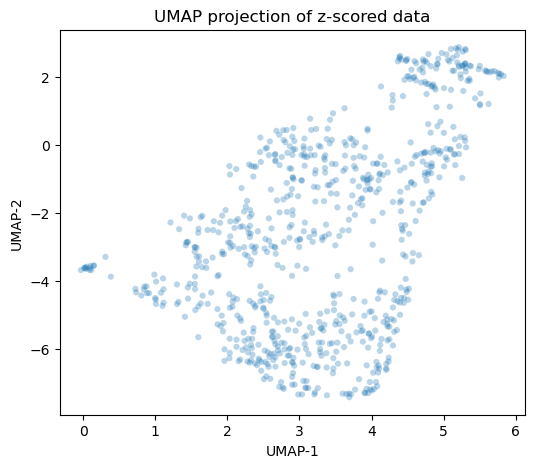

In [8]:
# UMAP projection of z-scored data
plt.figure(figsize=(6, 5))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    s=20,
    alpha=0.3,     
    edgecolor='none'
)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP projection of z-scored data")
plt.show()

In [9]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

results = {}

for k in range(3, 8):
    km = KMeans(
        n_clusters=k,
        n_init=50,
        random_state=42
    )
    labels = km.fit_predict(X_umap)

    results[k] = {
        "silhouette": silhouette_score(X_umap, labels),
        "davies_bouldin": davies_bouldin_score(X_umap, labels),
        "calinski_harabasz": calinski_harabasz_score(X_umap, labels)
    }


df_cluster_validity = (
    pd.DataFrame(results)
    .T
    .rename_axis("n_clusters")
    .reset_index()
)

np.round(df_cluster_validity,2)

C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,3,0.49,0.68,1437.97
1,4,0.50,0.69,1734.70
2,5,0.46,0.76,1650.90
3,6,0.45,0.78,1638.98
4,7,0.46,0.81,1738.43


# n_clusters = 3, UMAP + K-means Clustering(k = 3)

C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


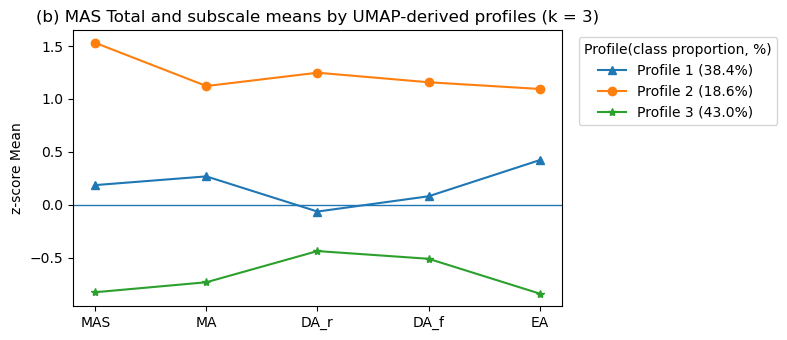

In [10]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_umap)
df['MAS'] =scaler.fit_transform(df[['MAS']])
df['labels'] = labels
d2 = df.groupby('labels')[['MAS','MA', 'DA_r',  'DA_f','EA']] \
  .agg(['mean', 'std'])


means = d2.xs('mean', level=1, axis=1)
means = means.rename(index = { 0 : 1 , 1: 3 })
rename_map = {0: 1, 1: 3}
label_df =np.round(df['labels'].value_counts() * 100/ len(df),1) 
label_df = label_df.rename(index = rename_map)
class_prop_raw = df['labels'].value_counts()

# rename 반영해서 새 인덱스로 맞춤
class_prop = class_prop_raw.rename(index=rename_map)
x = range(len(means.columns))          # 지표 개수
labels = means.columns.tolist()        # MAS_MA, MAS_DA, MAS_EA
# 프로파일 순서 고정
profile_order = [1, 2, 3]

# 프로파일별 색 지정
color_map = {
    2: 'tab:orange',
    1: 'tab:blue',   
    3: 'tab:green'     
}
markers = {
    1: "^",   # High
    3: "*",   # Moderate
    2: "o"    # Low
}

plt.figure(figsize=(8, 3.5))

for profile in profile_order:   # 🔹 순서를 여기서 강제로 1-2-3
    plt.plot(
        x,
        means.loc[profile],
        marker=markers[profile],
        label=f'Profile {profile} ({label_df.loc[profile]}%) ',
        color=color_map[profile]
    )

plt.xticks(x, labels)
plt.ylabel('z-score Mean')
plt.title('(b) MAS Total and subscale means by UMAP-derived profiles (k = 3)')
plt.axhline(0, linewidth=1)
plt.legend(
    title='Profile(class proportion, %)',
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.tight_layout()

plt.savefig(
    'profile_means_UMAP.jpg',
    dpi = 300,
    format="jpg",
    bbox_inches='tight'
)

plt.show()

C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


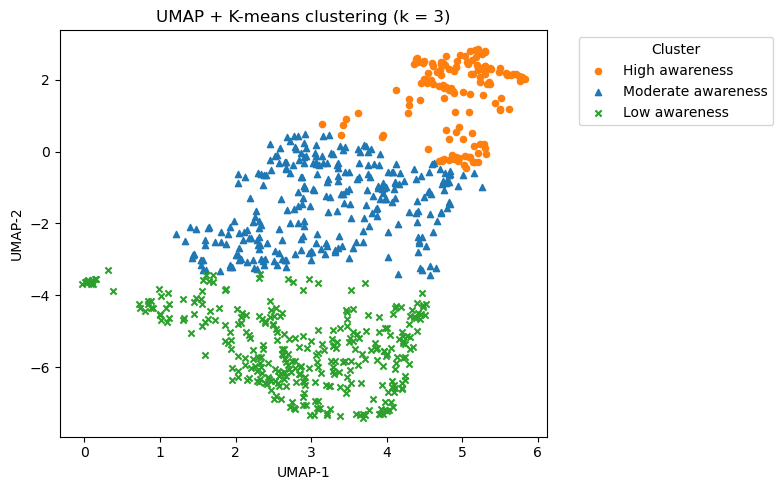

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
labels_int = kmeans.fit_predict(X_umap)

rename_map_for3 = {
    2: "High awareness",
    0: "Moderate awareness",
    1: "Low awareness"
}

color_map = {
    2: 'tab:orange',
    0: 'tab:blue',   
    1: 'tab:green'     
}

markers = {
    2: "o",   # High
    0: "^",   # Moderate
    1: "x"    # Low
}

plt.figure(figsize=(8, 5))

# ✅ 범례 순서 지정 (High → Moderate → Low)
plot_order = [2, 0, 1]

for cluster in plot_order:
    idx = (labels_int == cluster)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        marker=markers[cluster],
        color=color_map[cluster],
        s=20,
        label=f'{rename_map_for3[cluster]}'
    )

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP + K-means clustering (k = 3)")

plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(
    "UMAP-3cluster_fig.jpg",
    dpi=300,
    format="jpg",
    bbox_inches="tight"
)
plt.show()

In [12]:
#df['MAS'] is total score in the MAS scale
df['MAS'] =scaler.fit_transform(df[['MAS']])
labels = kmeans.fit_predict(X_umap)
df['labels'] = labels 

C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [13]:
#check propotion
np.round(df['labels'].value_counts() / len(df['labels']),2)

labels
1    0.43
0    0.38
2    0.19
Name: count, dtype: float64

In [14]:
da_r_columns = ['Q4_7',
'Q4_8',
'Q4_24',
'Q4_9',
'Q4_25',
'Q4_4',
'Q4_1']
da_r_df = df[da_r_columns]

In [15]:
# Extract total scale scores (last 17 columns) and apply z-score standardization (excluding cluster labels)
# to place all scale totals on a common metric for subsequent profile comparisons and interpretation.
total_df = df.iloc[:, -17:]
cols_to_scale = total_df.columns.drop(['labels'])
cols_to_scale_da_r = da_r_df.columns
da_r_df[cols_to_scale_da_r] = scaler.fit_transform(da_r_df[cols_to_scale_da_r])
total_df[cols_to_scale] = scaler.fit_transform(total_df[cols_to_scale])

C:\Users\sdoub\AppData\Local\Temp\ipykernel_18304\1266541896.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_r_df[cols_to_scale_da_r] = scaler.fit_transform(da_r_df[cols_to_scale_da_r])


In [16]:
#data preprocessing
total_df.columns.drop([ 'labels'])
da_r_df['labels'] = df['labels']

C:\Users\sdoub\AppData\Local\Temp\ipykernel_18304\476639718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_r_df['labels'] = df['labels']


In [18]:
da_r_df['labels'] = df['labels']
mean_df = total_df.groupby('labels').mean()
mean_df_da_r = da_r_df.groupby('labels').mean()

In [19]:
#DAta Preprocessing
rename_map = {
    'Total_Q2':  'AAQ_II',
    'Total_Q3':  'MC',
    'Total_Q4':  'MAS',
    'Total_Q6':  'EQ',
    'Total_Q7':  'FFMQ',
    'Total_Q8':  'SWLS',
    'Total_Q9':  'KEAT',
    'Total_Q11': 'PHQ',
    'Total_Q12': 'DASS',
    'Total_Q13': 'DERS'
}
mean_df_kr = mean_df.rename(columns=rename_map)
mean_df_kr = mean_df_kr.drop([ 'Total_Q5', 'Total_Q10' ], axis = 1)
total_df_kr = total_df.rename(columns=rename_map)
total_df_kr = total_df_kr.drop([ 'Total_Q5', 'Total_Q10','MA', 'DA_r','DA_f', 'EA' ], axis = 1)

mean_df_kr = mean_df_kr.rename(index={
    0: 'Moderate Awareness',
    1: 'Low Awareness',
    2: 'High Awareness',
})

In [20]:
mean_df_kr

,AAQ_II,MC,MAS,EQ,FFMQ,SWLS,KEAT,PHQ,DASS,DERS,MA,DA_r,DA_f,EA
labels,,,,,,,,,,,,,,
Moderate Awareness,0.056918,-0.031079,0.186028,0.007340,0.068011,-0.144512,-0.181838,-0.039743,-0.157151,-0.118380,0.284069,-0.084944,0.056922,0.424293
Low Awareness,-0.500133,0.287441,-0.826214,-0.449865,-0.612860,-0.175661,0.316754,0.313277,0.372579,0.403522,-0.760715,-0.466578,-0.565208,-0.856118
High Awareness,1.041060,-0.601699,1.529862,1.026977,1.279293,0.705307,-0.358326,-0.643661,-0.538618,-0.690353,1.175701,1.256239,1.191801,1.107177


In [21]:
#Preprocessing
new_order = [
    'AAQ_II', 'EQ', 'FFMQ', 'SWLS', 'KEAT',
    'PHQ', 'DASS', 'DERS',
    'MC', 'MAS',
    'MA', 'DA_r', 'DA_f', 'EA'
]
mean_df_kr = mean_df_kr[new_order]
mean_df_kr = mean_df_kr.sort_index()

In [27]:
labels = mean_df_kr.columns.tolist()[:-5]


['AAQ_II', 'EQ', 'FFMQ', 'SWLS', 'KEAT', 'PHQ', 'DASS', 'DERS', 'MC']

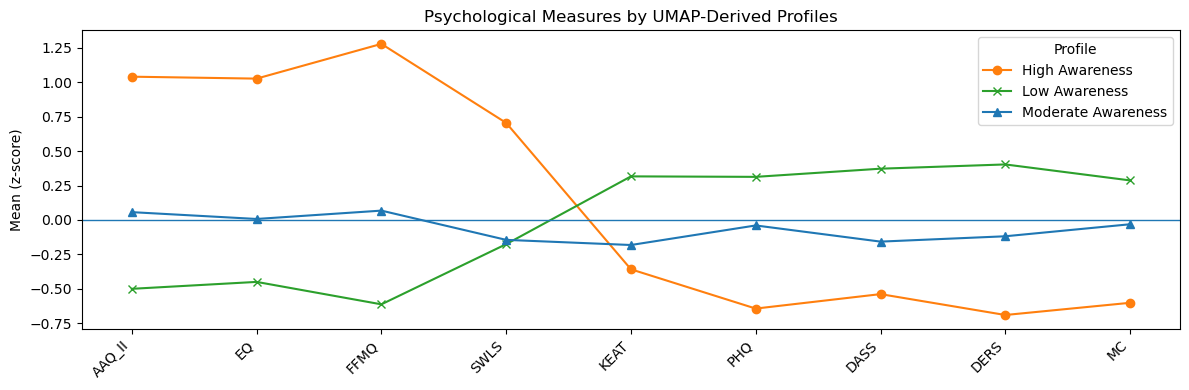

In [29]:
mean_df_kr = mean_df_kr.sort_index()
kmeans = KMeans(n_clusters=3, random_state=42)
x = range(len(labels))
profile_labels = {
    0: 'Moderate Awareness',
    1: 'Low Awareness',
    2: 'High Awareness'
}
color_map = {
    'High Awareness': 'tab:orange',
    'Moderate Awareness': 'tab:blue',   
    'Low Awareness': 'tab:green',
}

markers = {
    'High Awareness': "o",   # High
    'Moderate Awareness': "^",   # Moderate
    'Low Awareness': "x"    # Low
}

plt.figure(figsize=(12, 4))

for profile in mean_df_kr.index:
    plt.plot(
        x,
        mean_df_kr.loc[profile, labels].values,
        marker= markers[profile],
        color= color_map[profile],
        label=str(profile)
    )

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Mean (z-score)')
plt.title('Psychological Measures by UMAP-Derived Profiles')
plt.axhline(0, linewidth=1)
plt.legend(title='Profile')
plt.tight_layout()
plt.savefig(
    'profile_psyfucn_UMAP_3clusters.jpg',
    format = 'jpg',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

# n_clusters = 4, UMAP + K-means Clustering(k = 4)

C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


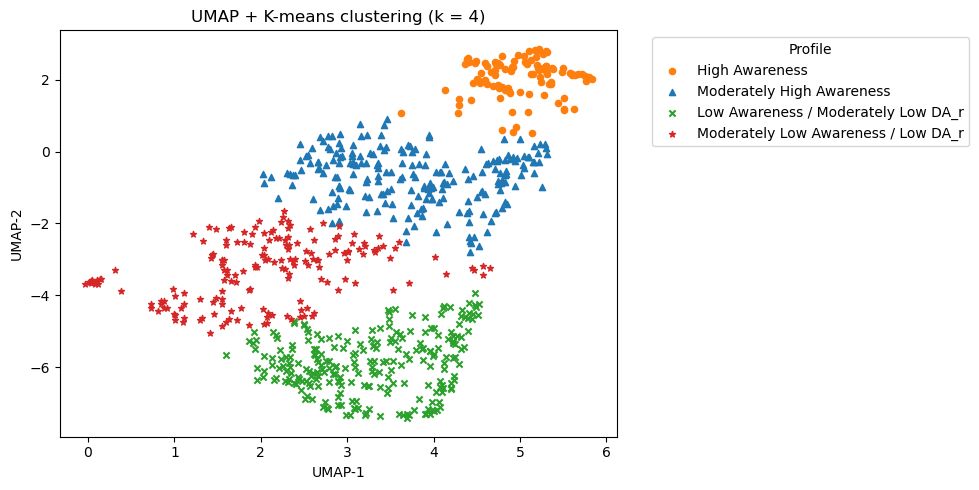

In [30]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels_int = kmeans.fit_predict(X_umap)

rename_map_for4 = {
    2: "High Awareness",
    0: "Moderately High Awareness",
    1: "Low Awareness / Moderately Low DA_r",
    3: "Moderately Low Awareness / Low DA_r"
}

color_map = {
    2: 'tab:orange',
   0: 'tab:blue',   
    1 : 'tab:green',
    3: 'tab:red'
}

markers = {
    2: "o",   # High
    0: "^",   # Moderate
    1: "x",    # Low
    3: "*"
}


plt.figure(figsize=(10, 5))

# ✅ 범례 순서 지정 (High → Moderate → Low)
plot_order = [2, 0, 1, 3]

for cluster in plot_order:
    idx = (labels_int == cluster)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        marker=markers[cluster],
        color = color_map[cluster],
        s=20,
        label=rename_map_for4[cluster]
    )

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP + K-means clustering (k = 4)")

plt.legend(title="Profile", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(
    "UMAP-4cluster_fig.jpg",
    dpi=300,
    format="jpg",
    bbox_inches="tight"
)
plt.show()

In [31]:
#Preprocessing
labels = kmeans.fit_predict(X_umap)
mean_df_da_r_kr = mean_df_da_r.rename(index={
    0: 'Moderately High Awareness',
    1: 'Low Awareness / Moderately low DA_r',
    2: 'High Awareness',
    3: 'Moderately Low Awareness / Low DA_r',
})
df['labels'] = labels

C:\Users\sdoub\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


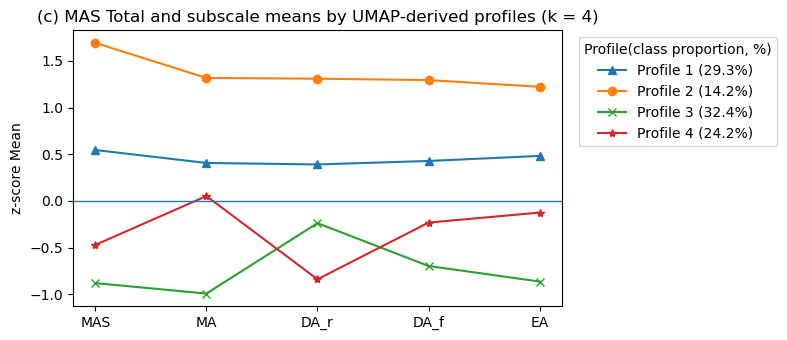

In [32]:
d2 = df.groupby('labels')[['MAS','MA', 'DA_r',  'DA_f','EA']] \
  .agg(['mean', 'std'])


means = d2.xs('mean', level=1, axis=1)

x = range(len(means.columns))          # 지표 개수
labels = means.columns.tolist()        # MAS_MA, MAS_DA, MAS_EA
rename_map = {0: 1, 1: 3, 3:4}
means = means.rename(index = rename_map)
profile_order = [1, 2, 3, 4]
plt.figure(figsize=(8, 3.5))
label_df =np.round(df['labels'].value_counts() * 100/ len(df),1) 
label_df = label_df.rename(index = rename_map)
markers = {
    2: "o",   # High
    0: "^",   # Moderate
    1: "^",
    3: "x",# Low
    4: '*'
}

for profile in profile_order:
    plt.plot(
        x,
        means.loc[profile],
        marker=markers[profile],
        label=f'Profile {profile} ({label_df.loc[profile]}%) '
    )

plt.xticks(x, labels)
plt.ylabel('z-score Mean')
plt.title('(c) MAS Total and subscale means by UMAP-derived profiles (k = 4)')
plt.axhline(0, linewidth=1)
plt.legend(
    title='Profile(class proportion, %)',
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.tight_layout()
# 🔽 여기!
plt.savefig(
    'profile_means_UMAP_4cluster_fic.jpg',
    dpi=300,
    format = 'jpg',
    bbox_inches='tight'
)

plt.show()
# 알아차림 저 중고 그룹 


In [40]:
# This code performs Tukey’s HSD post-hoc tests for each variable in vars_to_test
# to examine pairwise mean differences across the profile/cluster groups (labels).
# For each variable, the Tukey results are converted into a DataFrame, tagged with
# the corresponding variable name, and then concatenated into a single summary table.

import pandas as pd

# 
total_df_kr = total_df_kr.rename(columns={'AAQ-II': 'AAQ_II'})
total_df_kr.columns = total_df_kr.columns.str.replace('-', '_', regex=False)

# 
vars_to_test = total_df_kr.columns.drop('labels')

results = []
for v in vars_to_test:
    model = ols(f'{v} ~ C(labels)', data=total_df_kr).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    results.append({
        'variable': v,
        'n': int(model.nobs),
        'F': float(anova.loc['C(labels)', 'F']),
        'p': float(anova.loc['C(labels)', 'PR(>F)'])
    })

anova_df = pd.DataFrame(results).sort_values('p')
anova_df

,variable,n,F,p
2,MAS,748,981.714865,4.151274e-258
4,FFMQ,748,278.956594,2.731147e-121
0,AAQ_II,748,153.814479,1.476027e-77
3,EQ,748,140.009393,6.376191e-72
9,DERS,748,82.780290,3.209050e-46
7,PHQ,748,50.685000,8.174363e-30
8,DASS,748,41.164567,1.283442e-24
1,MC,748,35.017632,3.547089e-21
5,SWLS,748,34.618266,5.968555e-21
6,KEAT,748,20.401825,1.031216e-12


In [34]:
#pairwise_analysis
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pairwise_results = []

for v in vars_to_test:
    tukey = pairwise_tukeyhsd(
        endog=total_df_kr[v],
        groups=total_df_kr['labels'],
        alpha=0.05
    )
    
    df_tukey = pd.DataFrame(
        data=tukey.summary().data[1:],
        columns=tukey.summary().data[0]
    )
    df_tukey['variable'] = v
    pairwise_results.append(df_tukey)

pairwise_df = pd.concat(pairwise_results, ignore_index=True)
pairwise_df

,group1,group2,meandiff,p-adj,lower,upper,reject,variable
0,0,1,-0.5571,0.0000,-0.7157,-0.3984,True,AAQ_II
1,0,2,0.9841,0.0000,0.7822,1.1861,True,AAQ_II
2,1,2,1.5412,0.0000,1.3429,1.7395,True,AAQ_II
3,0,1,0.3185,0.0001,0.1376,0.4994,True,MC
4,0,2,-0.5706,0.0000,-0.8009,-0.3403,True,MC
5,1,2,-0.8891,0.0000,-1.1153,-0.6630,True,MC
6,0,1,-1.0122,0.0000,-1.1093,-0.9152,True,MAS
7,0,2,1.3438,0.0000,1.2203,1.4673,True,MAS
8,1,2,2.3561,0.0000,2.2348,2.4774,True,MAS
9,0,1,-0.4572,0.0000,-0.6189,-0.2955,True,EQ


In [78]:
MAS_total_score =df.iloc[:, 42:67].sum(axis=1)
df['MAS'] = MAS_total_score
df['MAS'] = scaler.fit_transform(df[['MAS']])
anava_target_df = df[['MAS', 'MA', 'DA_r', 'DA_f', 'labels']]
anava_target_df

,MAS,MA,DA_r,DA_f,labels
0,0.035950,-0.351316,0.009847,-0.355932,3
1,0.153634,0.447130,-0.533455,0.038453,0
2,0.506687,0.646741,0.553149,0.038453,0
3,-0.258260,-0.950151,0.009847,-0.947509,3
4,-0.199418,1.644799,-2.163361,0.827222,3
...,...,...,...,...,...
743,-0.905523,-0.750539,-0.533455,0.038453,1
744,-0.787839,-0.750539,-0.669280,0.235645,1
745,1.330476,1.445188,1.775579,1.615991,2
746,2.095423,1.844411,1.232277,1.418799,2


In [81]:
from statsmodels.formula.api import ols
import statsmodels.api as sm




vars_to_test = anava_target_df.columns.drop('labels')

results = []
for v in vars_to_test:
    print(v)
    model = ols(f'{v} ~ C(labels)', data=anava_target_df).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    results.append({
        'variable': v,
        'n': int(model.nobs),
        'F': np.round(float(anova.loc['C(labels)', 'F']), 2),
        'p': float(anova.loc['C(labels)', 'PR(>F)'])
    })

anova_df = pd.DataFrame(results).sort_values('p')
anova_df

MAS
MA
DA_r
DA_f


,variable,n,F,p
0,MAS,748,981.71,4.151274e-258
1,MA,748,503.85,1.163571e-178
3,DA_f,748,259.63,2.924917e-115
2,DA_r,748,245.93,7.582017e-111


In [104]:
# Extract total scale scores (last 17 columns) and apply z-score standardization (excluding cluster labels)
# to place all scale totals on a common metric for subsequent profile comparisons and interpretation.
total_df = df.iloc[:, -17:]
cols_to_scale = total_df.columns.drop(['labels'])
cols_to_scale_da_r = da_r_df.columns
da_r_df[cols_to_scale_da_r] = scaler.fit_transform(da_r_df[cols_to_scale_da_r])
total_df[cols_to_scale] = scaler.fit_transform(total_df[cols_to_scale])

C:\Users\sdoub\AppData\Local\Temp\ipykernel_18304\1266541896.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_r_df[cols_to_scale_da_r] = scaler.fit_transform(da_r_df[cols_to_scale_da_r])


In [105]:
#data preprocessing
total_df.columns.drop([ 'labels'])
da_r_df['labels'] = df['labels']

C:\Users\sdoub\AppData\Local\Temp\ipykernel_18304\476639718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_r_df['labels'] = df['labels']


In [106]:
mean_df = total_df.groupby('labels').mean()
mean_df_da_r = da_r_df.groupby('labels').mean()

In [119]:
#DAta Preprocessing
rename_map = {
    'Total_Q2':  'AAQ_II',
    'Total_Q3':  'MC',
    'Total_Q4':  'MAS',
    'Total_Q6':  'EQ',
    'Total_Q7':  'FFMQ',
    'Total_Q8':  'SWLS',
    'Total_Q9':  'KEAT',
    'Total_Q11': 'PHQ',
    'Total_Q12': 'DASS',
    'Total_Q13': 'DERS'
}
mean_df_kr = mean_df.rename(columns=rename_map)
mean_df_kr = mean_df_kr.drop([ 'Total_Q5', 'Total_Q10' ], axis = 1)
total_df_kr = total_df.rename(columns=rename_map)
total_df_kr = total_df_kr.drop([ 'Total_Q5', 'Total_Q10','MA', 'DA_r','DA_f', 'EA' ], axis = 1)

mean_df_kr = mean_df_kr.rename(index={
    0: 'Moderate Awareness',
    1: 'Low Awareness',
    2: 'High Awareness',
})

In [120]:
total_df_kr['labels'] = df.labels

In [121]:

mean_df = total_df_kr.groupby('labels').mean()
mean_df_kr = mean_df.groupby('labels').mean()
mean_df_kr = mean_df_kr.sort_index()

In [122]:
rename_map = {
    0: 'Moderately High Awareness',
    1: 'Low Awareness / Moderately low DA_r',
    2: 'High Awareness',
    3: 'Moderately Low Awareness / Low DA_r',
}
mean_df_kr = mean_df_kr.rename(index = rename_map)
#Preprocessing
new_order = [
    'AAQ_II', 'EQ', 'FFMQ', 'SWLS', 'KEAT',
    'PHQ', 'DASS', 'DERS',
    'MC']
mean_df_kr = mean_df_kr[new_order]
mean_df_kr = mean_df_kr.sort_index()

Index(['High Awareness', 'Low Awareness / Moderately low DA_r',
       'Moderately High Awareness', 'Moderately Low Awareness / Low DA_r'],
      dtype='object', name='labels')
['MAS', 'MA', 'DA_r', 'DA_f', 'EA']


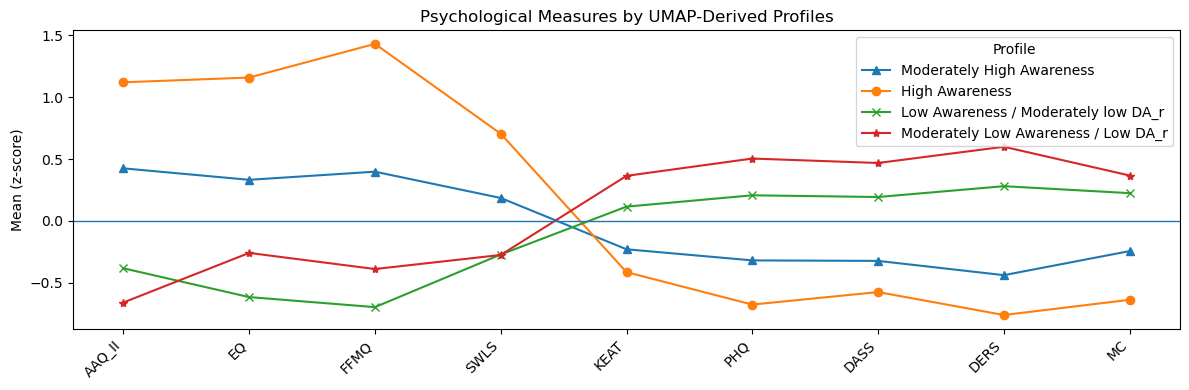

In [123]:




cols_front = mean_df_kr.columns
print(mean_df_kr.index)
x = range(len(cols_front))


profile_labels = {
    0: 'Moderately High Awareness',
    1: 'Low Awareness / Moderately low DA_r',
    2: 'High Awareness',
    3: 'Moderately Low Awareness / Low DA_r',
}
color_map = {
    'High Awareness': 'tab:orange',
    'Moderately High Awareness': 'tab:blue',   
    'Low Awareness / Moderately low DA_r' : 'tab:green',
    'Moderately Low Awareness / Low DA_r': 'tab:red'
}

markers = {
    'High Awareness': "o",   # High
    'Moderately High Awareness': "^",   # Moderate
    'Low Awareness / Moderately low DA_r': "x",    # Low
    'Moderately Low Awareness / Low DA_r': "*"
}
profile_order = ['Moderately High Awareness', 'High Awareness', 'Low Awareness / Moderately low DA_r', 'Moderately Low Awareness / Low DA_r']

plt.figure(figsize=(12, 4))
print(labels)
for profile in profile_order:
    plt.plot(
        x,
        mean_df_kr.loc[profile, cols_front].values,
        marker= markers[profile],
        color= color_map[profile],
        label=str(profile)
    )

plt.xticks(x, cols_front, rotation=45, ha='right')
plt.ylabel('Mean (z-score)')
plt.title('Psychological Measures by UMAP-Derived Profiles')
plt.axhline(0, linewidth=1)
plt.legend(title='Profile')
plt.tight_layout()
plt.savefig(
    'psychological_Measures_UMAP_4clusters.jpg',
    format = 'jpg',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

# Item-Level analysis,(k = 4)

In [124]:
da_r_columns = ['Q4_7',
'Q4_8',
'Q4_24',
'Q4_9',
'Q4_25',
'Q4_4',
'Q4_1']
da_r_df = df[da_r_columns]

In [125]:
total_df = df.iloc[:, -17:]
cols_to_scale = total_df.columns.drop([ 'labels'])
cols_to_scale_da_r = da_r_df.columns
da_r_df[cols_to_scale_da_r] = scaler.fit_transform(da_r_df[cols_to_scale_da_r])
total_df[cols_to_scale] = scaler.fit_transform(total_df[cols_to_scale])
total_df.columns.drop([ 'labels'])
da_r_df['labels'] = df['labels']
mean_df = total_df.groupby('labels').mean()
mean_df_da_r = da_r_df.groupby('labels').mean()

C:\Users\sdoub\AppData\Local\Temp\ipykernel_18304\2727351429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_r_df[cols_to_scale_da_r] = scaler.fit_transform(da_r_df[cols_to_scale_da_r])
C:\Users\sdoub\AppData\Local\Temp\ipykernel_18304\2727351429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_r_df['labels'] = df['labels']


In [150]:
rename_map = {
    'Total_Q2':  'AAQ_II',
    'Total_Q3':  'MC',
    'Total_Q4':  'MAS',
    'Total_Q6':  'EQ',
    'Total_Q7':  'FFMQ',
    'Total_Q8':  'SWLS',
    'Total_Q9':  'KEAT',
    'Total_Q11': 'PHQ',
    'Total_Q12': 'DASS',
    'Total_Q13': 'DERS'
}

In [152]:
lis = []
for i in rename_map.keys():
    if i != 'Total_Q4':
        print(i)
        lis.append(i)
        print(lis)

Total_Q2
['Total_Q2']
Total_Q3
['Total_Q2', 'Total_Q3']
Total_Q6
['Total_Q2', 'Total_Q3', 'Total_Q6']
Total_Q7
['Total_Q2', 'Total_Q3', 'Total_Q6', 'Total_Q7']
Total_Q8
['Total_Q2', 'Total_Q3', 'Total_Q6', 'Total_Q7', 'Total_Q8']
Total_Q9
['Total_Q2', 'Total_Q3', 'Total_Q6', 'Total_Q7', 'Total_Q8', 'Total_Q9']
Total_Q11
['Total_Q2', 'Total_Q3', 'Total_Q6', 'Total_Q7', 'Total_Q8', 'Total_Q9', 'Total_Q11']
Total_Q12
['Total_Q2', 'Total_Q3', 'Total_Q6', 'Total_Q7', 'Total_Q8', 'Total_Q9', 'Total_Q11', 'Total_Q12']
Total_Q13
['Total_Q2', 'Total_Q3', 'Total_Q6', 'Total_Q7', 'Total_Q8', 'Total_Q9', 'Total_Q11', 'Total_Q12', 'Total_Q13']


In [153]:
total_score_df = df[lis]

In [154]:
total_score_df['labels'] = df['labels']

C:\Users\sdoub\AppData\Local\Temp\ipykernel_18304\101795992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_score_df['labels'] = df['labels']


In [155]:
total_score_df =total_score_df.rename(columns = rename_map)

In [156]:
total_score_df.columns[:-1]

Index(['AAQ_II', 'MC', 'EQ', 'FFMQ', 'SWLS', 'KEAT', 'PHQ', 'DASS', 'DERS'], dtype='object')

In [157]:
g = total_score_df.groupby('labels')
mean = g.mean()
se   = g.std() / np.sqrt(748)   # n이 진짜로 748로 고정일 때만
out = pd.concat([mean, se], axis=1, keys=['mean', 'se']).round(3).T
np.round(out, 2)

labels           0      1      2      3
mean AAQ_II  41.29  34.87  46.82  32.67
     MC      18.26  19.58  17.16  19.98
     EQ      37.64  30.91  43.50  33.44
     FFMQ    69.89  58.31  80.81  61.56
     SWLS    20.45  17.47  23.83  17.45
     KEAT    58.23  64.61  54.81  69.21
     PHQ      1.18   2.02   0.60   2.50
     DASS     1.98   3.90   1.05   4.92
     DERS    24.74  34.30  20.45  38.54
se   AAQ_II   0.22   0.24   0.17   0.25
     MC       0.10   0.11   0.09   0.09
     EQ       0.19   0.22   0.15   0.23
     FFMQ     0.26   0.29   0.30   0.22
     SWLS     0.23   0.20   0.23   0.24
     KEAT     0.56   0.65   0.44   0.84
     PHQ      0.05   0.06   0.04   0.06
     DASS     0.10   0.14   0.06   0.16
     DERS     0.34   0.49   0.26   0.49

In [158]:
MAS_MA_items = [ "Q4_13", "Q4_10", "Q4_2", "Q4_5",  "Q4_21",  "Q4_23" ]
MAS_DA_r_items = [  "Q4_7", "Q4_8",  "Q4_24",  "Q4_9",  "Q4_25",  "Q4_4",  "Q4_1"
] 
MAS_DA_f_items = [  "Q4_19",  "Q4_20", "Q4_17", "Q4_18", "Q4_15", "Q4_11" ]

MAS_EA_items = [ "Q4_12", "Q4_14", "Q4_22",
    "Q4_6",
    "Q4_16",
    "Q4_3",
]

In [159]:
reversed_df = df.copy()
#하위척도별 합산 구함
reversed_df['MAS_MA_items'] = reversed_df[MAS_MA_items].sum(axis = 1)
reversed_df['MAS_DA_r_items'] = reversed_df[MAS_DA_r_items].sum(axis = 1)
reversed_df['MAS_DA_f_items'] = reversed_df[MAS_DA_f_items].sum(axis = 1)
reversed_df['MAS_EA_items'] = reversed_df[MAS_EA_items].sum(axis = 1)
reversed_df['MAS_items'] = reversed_df.iloc[:,-4:].sum(axis = 1)
reversed_df['labels'] = df['labels']

In [160]:
g = da_r_df.groupby('labels')[MAS_DA_r_items]
mean = g.mean()
se   = g.std() / np.sqrt(748)   
out = pd.concat([mean, se], axis=1, keys=['mean', 'se']).round(3).T
np.round(out, 2)


labels         0     1     2     3
mean Q4_7   0.26 -0.19  1.17 -0.75
     Q4_8   0.34 -0.25  1.24 -0.80
     Q4_24  0.28 -0.24  1.08 -0.65
     Q4_9   0.24 -0.14  1.00 -0.68
     Q4_25  0.47 -0.41  1.12 -0.67
     Q4_4  -0.02  0.33  0.12 -0.48
     Q4_1   0.43 -0.45  1.16 -0.59
se   Q4_7   0.03  0.03  0.02  0.03
     Q4_8   0.03  0.03  0.02  0.03
     Q4_24  0.03  0.03  0.03  0.03
     Q4_9   0.03  0.03  0.03  0.03
     Q4_25  0.02  0.03  0.02  0.03
     Q4_4   0.04  0.03  0.05  0.03
     Q4_1   0.03  0.03  0.03  0.03

In [161]:
mean_df = mean_df.rename(columns={
    'Q4_1': 'Q1',
    'Q4_4': 'Q4',
    'Q4_7': 'Q7',
    'Q4_8': 'Q8',
    'Q4_9': 'Q9',
    'Q4_24': 'Q24',
    'Q4_25': 'Q25',
})

In [162]:
mean_df = mean_df.rename(index={
    0: 'Moderately High Awareness',
    1: 'Low Awareness / Moderately low DA_r',
    2: 'High Awareness',
    3: 'Moderately Low Awareness / Low DA_r',
})

In [163]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import pandas as pd

# 1) 하이픈 제거(권장)
total_df_kr = da_r_df
total_df_kr.columns = total_df_kr.columns.str.replace('-', '_', regex=False)

# 2) 검정 변수 선택(안전)
vars_to_test = total_df_kr.columns.drop('labels')

results = []
for v in vars_to_test:
    model = ols(f'{v} ~ C(labels)', data=total_df_kr).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    results.append({
        'variable': v,
        'n': int(model.nobs),
        'F': np.round(float(anova.loc['C(labels)', 'F']), 2),
        'p': float(anova.loc['C(labels)', 'PR(>F)'])
    })

anova_df = pd.DataFrame(results).sort_values('p')
anova_df

,variable,n,F,p
1,Q4_8,748,186.00,5.535607e-90
4,Q4_25,748,168.52,2.365513e-83
6,Q4_1,748,162.63,4.668913e-81
0,Q4_7,748,140.48,4.055813e-72
2,Q4_24,748,109.24,1.302798e-58
3,Q4_9,748,94.63,6.941357e-52
5,Q4_4,748,25.48,1.063439e-15


In [164]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Q4_4 데이터만 추출
df_q4_4 = total_df_kr[['Q4_4', 'labels']].dropna()

tukey = pairwise_tukeyhsd(
    endog=df_q4_4['Q4_4'],
    groups=df_q4_4['labels'],
    alpha=0.05
)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.3473 0.0006   0.118  0.5766   True
     0      2   0.1425 0.5882 -0.1484  0.4334  False
     0      3  -0.4623    0.0 -0.7092 -0.2153   True
     1      2  -0.2048 0.2547 -0.4912  0.0815  False
     1      3  -0.8096    0.0 -1.0512  -0.568   True
     2      3  -0.6047    0.0 -0.9054  -0.304   True
----------------------------------------------------


In [165]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import pandas as pd

# 1) 하이픈 제거(권장)
total_df_kr = reversed_df.iloc[:,-6:]
total_df_kr.columns = total_df_kr.columns.str.replace('-', '_', regex=False)

# 2) 검정 변수 선택(안전)
vars_to_test = total_df_kr.columns.drop('labels')

results = []
for v in vars_to_test:
    model = ols(f'{v} ~ C(labels)', data=total_df_kr).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    results.append({
        'variable': v,
        'n': int(model.nobs),
        'F': np.round(float(anova.loc['C(labels)', 'F']), 2),
        'p': float(anova.loc['C(labels)', 'PR(>F)'])
    })

anova_df = pd.DataFrame(results).sort_values('p')
anova_df

,variable,n,F,p
4,MAS_items,748,981.71,4.151274e-258
0,MAS_MA_items,748,503.85,1.163571e-178
3,MAS_EA_items,748,292.89,1.681984e-125
2,MAS_DA_f_items,748,259.63,2.924917e-115
1,MAS_DA_r_items,748,245.93,7.582017e-111


In [166]:
g = da_r_df.groupby('labels')[MAS_DA_r_items]
mean = g.mean()
se   = g.std() / np.sqrt(748)   # n이 진짜로 748로 고정일 때만

out = pd.concat([mean, se], axis=1, keys=['mean', 'se']).round(3).T
out

labels          0      1      2      3
mean Q4_7   0.263 -0.187  1.168 -0.752
     Q4_8   0.339 -0.253  1.244 -0.801
     Q4_24  0.278 -0.239  1.075 -0.646
     Q4_9   0.235 -0.142  1.000 -0.680
     Q4_25  0.470 -0.413  1.115 -0.670
     Q4_4  -0.021  0.327  0.122 -0.483
     Q4_1   0.426 -0.454  1.164 -0.590
se   Q4_7   0.032  0.027  0.021  0.033
     Q4_8   0.030  0.028  0.021  0.028
     Q4_24  0.032  0.029  0.028  0.032
     Q4_9   0.034  0.031  0.032  0.027
     Q4_25  0.025  0.029  0.025  0.033
     Q4_4   0.035  0.031  0.046  0.031
     Q4_1   0.032  0.026  0.026  0.030

In [167]:

g = total_df_kr.groupby('labels')
mean = g.mean()
se   = g.std() / np.sqrt(748)   # n이 진짜로 748로 고정일 때만

out = pd.concat([mean, se], axis=1, keys=['mean', 'se']).round(2).T
out

labels                    0       1       2       3
mean MAS_MA_items     30.79   23.78   35.36   29.02
     MAS_DA_r_items   32.80   28.17   39.57   23.74
     MAS_DA_f_items   28.97   23.26   33.37   25.62
     MAS_EA_items     32.08   25.20   35.87   28.98
     MAS_items       124.65  100.41  144.16  107.36
se   MAS_MA_items      0.10    0.10    0.08    0.11
     MAS_DA_r_items    0.18    0.20    0.15    0.20
     MAS_DA_f_items    0.11    0.13    0.11    0.14
     MAS_EA_items      0.12    0.11    0.12    0.15
     MAS_items         0.24    0.34    0.26    0.24

In [168]:
np.round(da_r_df.groupby('labels').mean(), 2)

,Q4_7,Q4_8,Q4_24,Q4_9,Q4_25,Q4_4,Q4_1
labels,,,,,,,
0,0.26,0.34,0.28,0.23,0.47,-0.02,0.43
1,-0.19,-0.25,-0.24,-0.14,-0.41,0.33,-0.45
2,1.17,1.24,1.07,1.00,1.11,0.12,1.16
3,-0.75,-0.80,-0.65,-0.68,-0.67,-0.48,-0.59


In [169]:
mean_df = mean_df.rename(columns={
    'Q4_1': 'Q1',
    'Q4_4': 'Q4',
    'Q4_7': 'Q7',
    'Q4_8': 'Q8',
    'Q4_9': 'Q9',
    'Q4_24': 'Q24',
    'Q4_25': 'Q25',
})

In [170]:
mean_df = mean_df.rename(index={
    0: 'Moderately High Awareness',
    1: 'Low Awareness / Moderately low DA_r',
    2: 'High Awareness',
    3: 'Moderately Low Awareness / Low DA_r',
})

In [171]:
MAS_FACTORS = {
    "MA":   [2, 5, 10, 13, 21, 23],
    "DA_r": [1, 4, 7, 8, 9, 24, 25],
    "DA_f": [11, 15, 17, 18, 19, 20],
    "EA":   [3, 6, 12, 14, 16, 22]
}


MAS_ITEM_COLS = {
    factor: [f"Q4_{i}" for i in items]
    for factor, items in MAS_FACTORS.items()
}

In [172]:
mean_df = df.groupby("labels").mean()

mas_factor_df = pd.DataFrame({
    f: mean_df[cols].mean(axis=1)
    for f, cols in MAS_ITEM_COLS.items()
})

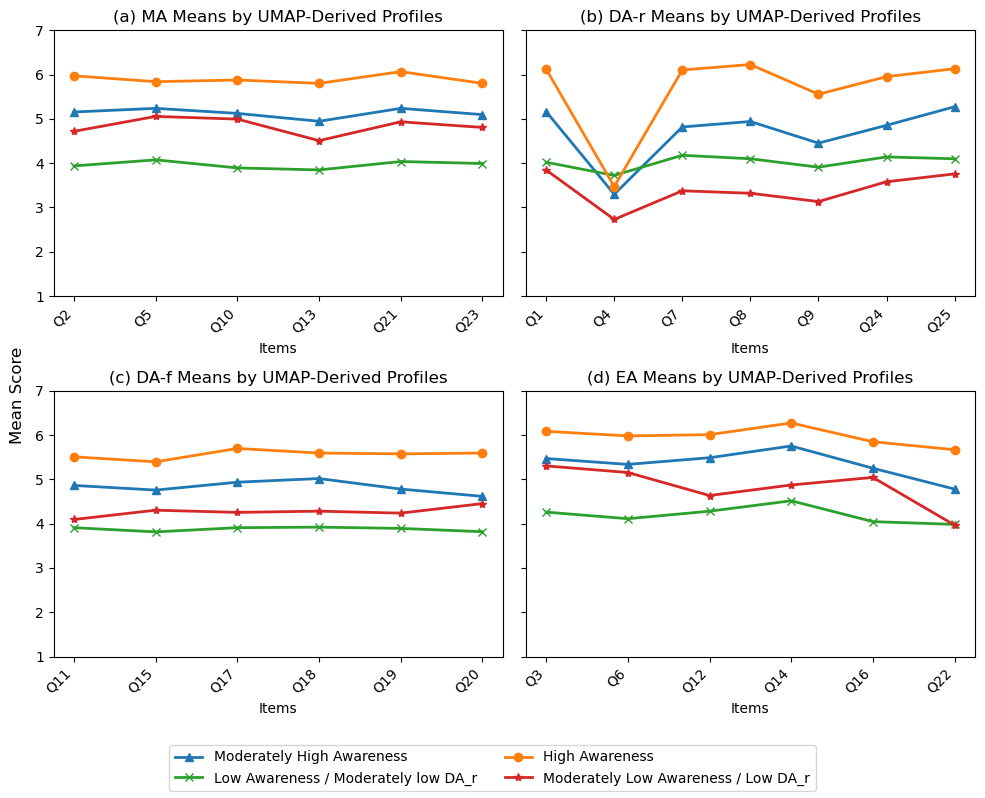

In [173]:
import matplotlib.pyplot as plt

factors = ["MA", "DA_r", "DA_f", "EA"]
titles = {
    "MA":   "(a) MA Means by UMAP-Derived Profiles",
    "DA_r": "(b) DA-r Means by UMAP-Derived Profiles",
    "DA_f": "(c) DA-f Means by UMAP-Derived Profiles",
    "EA":   "(d) EA Means by UMAP-Derived Profiles"
}

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()
profile_labels = {
    0: 'Moderately High Awareness',
    1: 'Low Awareness / Moderately low DA_r',
    2: 'High Awareness',
    3: 'Moderately Low Awareness / Low DA_r',
}
color_map = {
    'High Awareness': 'tab:orange',
    'Moderately High Awareness': 'tab:blue',   
    'Low Awareness / Moderately low DA_r' : 'tab:green',
    'Moderately Low Awareness / Low DA_r': 'tab:red'
}

markers = {
    'High Awareness': "o",   # High
    'Moderately High Awareness': "^",   # Moderate
    'Low Awareness / Moderately low DA_r': "x",    # Low
    'Moderately Low Awareness / Low DA_r': "*"
}

for ax, factor in zip(axes, factors):

    item_mean = (
        df.groupby("labels")[MAS_ITEM_COLS[factor]]
          .mean()
          .rename(index=profile_labels)
    )

    for label in item_mean.index:
        ax.plot(
            range(item_mean.shape[1]),
            item_mean.loc[label],
            marker=markers[label], 
            linewidth=2,
            color = color_map[label],
            label=f"{label}"
        )

    xtick_labels = [c.replace("Q4_", "Q") for c in MAS_ITEM_COLS[factor]]
    ax.set_xticks(range(item_mean.shape[1]))
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right")

    ax.set_title(titles[factor])
    ax.set_xlabel("Items")
    ax.set_ylim(1, 7)
    ax.set_yticks(range(1, 8))

# ✅ 범례는 한 번만 (공통)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=2,
    frameon=True
)

fig.supylabel("Mean Score")
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig(
    "Figure_DA_item_means.jpg",
    dpi=300,
    format = 'jpg',
    bbox_inches="tight"
)
plt.show()

In [174]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import pandas as pd

# 1) 하이픈 제거(권장)
total_df_kr = da_r_df
total_df_kr.columns = total_df_kr.columns.str.replace('-', '_', regex=False)

# 2) 검정 변수 선택(안전)
vars_to_test = total_df_kr.columns.drop('labels')

results = []
for v in vars_to_test:
    model = ols(f'{v} ~ C(labels)', data=total_df_kr).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    results.append({
        'variable': v,
        'n': int(model.nobs),
        'F': np.round(float(anova.loc['C(labels)', 'F']), 2),
        'p': float(anova.loc['C(labels)', 'PR(>F)'])
    })

anova_df = pd.DataFrame(results).sort_values('p')
anova_df

,variable,n,F,p
1,Q4_8,748,186.00,5.535607e-90
4,Q4_25,748,168.52,2.365513e-83
6,Q4_1,748,162.63,4.668913e-81
0,Q4_7,748,140.48,4.055813e-72
2,Q4_24,748,109.24,1.302798e-58
3,Q4_9,748,94.63,6.941357e-52
5,Q4_4,748,25.48,1.063439e-15


In [175]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Q4_4 데이터만 추출
df_q4_4 = total_df_kr[['Q4_4', 'labels']].dropna()

tukey = pairwise_tukeyhsd(
    endog=df_q4_4['Q4_4'],
    groups=df_q4_4['labels'],
    alpha=0.05
)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.3473 0.0006   0.118  0.5766   True
     0      2   0.1425 0.5882 -0.1484  0.4334  False
     0      3  -0.4623    0.0 -0.7092 -0.2153   True
     1      2  -0.2048 0.2547 -0.4912  0.0815  False
     1      3  -0.8096    0.0 -1.0512  -0.568   True
     2      3  -0.6047    0.0 -0.9054  -0.304   True
----------------------------------------------------
